In [1]:
import pylab as py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
medical_data = pd.read_csv("dataset/other_train.csv")
personal_data = pd.read_csv("dataset/personal_train.csv")

V predchádzajúcej časti sme v oboch súboroch idetifikovali dva nepomenované stĺpce, ktoré pre nás nemajú žiaden význam,
takže ich teraz môžeme z oboch datasetov odstrániť.

In [3]:
personal_data = personal_data.drop(personal_data.columns[0], axis=1)
medical_data = medical_data.drop(medical_data.columns[0], axis=1)

Dáta spojíme do jednej tabuľky, keďže jedno pozorovanie musí byť opísané len jedným riadkom.

In [4]:
data = pd.merge(personal_data, medical_data, on = ["name", "address"], how = "outer")
data_backup = data

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3983 entries, 0 to 3982
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              3983 non-null   object 
 1   address           3983 non-null   object 
 2   age               3983 non-null   int64  
 3   sex               3983 non-null   object 
 4   date_of_birth     3983 non-null   object 
 5   kurtosis_oxygen   3974 non-null   float64
 6   pregnant          3971 non-null   object 
 7   education-num     3579 non-null   float64
 8   relationship      3961 non-null   object 
 9   skewness_glucose  3965 non-null   float64
 10  mean_glucose      3963 non-null   float64
 11  std_oxygen        3967 non-null   float64
 12  capital-gain      3969 non-null   float64
 13  skewness_oxygen   3975 non-null   float64
 14  kurtosis_glucose  3968 non-null   float64
 15  personal_info     3974 non-null   object 
 16  education         3971 non-null   object 


Ako prvé môžeme premenovať stĺpce class a fnlwgt, aby ich názvy boli viacej informatívne.

In [5]:
def rename_columns(X):
    X = X.rename(columns = {'fnlwgt': 'final_weight', 'class': 'diabetes_presence'}, inplace = False)
    return X

### Úprava chybných atribútov

V tejto časti opravíme chyby, ktoré sme idetifikovali v predchádzajúcej časti projektu, prípadne aj novo-objavené chyby,
ak na ne narazíme.


V doleuvedenej tabuľke vidíme chybu v atribúte age. Minimálny vek má hodnotu -1, čo je samozrejme nesprávne. Môžeme to
vyriešiť, tak, že vyrátame nový vek pacienta, keďže máme aj atribút date_of_birth. Toto funguje len za predpokladu, že
date_of_birth nemá nulovú hodnotu a bol zadaný správne. Iným riešením by mohlo byť nahradenie záporného veku
priemerným, alebo najčastejšie sa vyskytujúcim vekom všetkých pacientov.

In [6]:
data["age"].describe()

count    3983.000000
mean       51.844841
std        11.797919
min        -1.000000
25%        44.000000
50%        52.000000
75%        60.000000
max       113.000000
Name: age, dtype: float64

Každý pacient má zadaný vek a dátum narodenia, čiže môžeme vytvoriť funkciu, ktorá vyráta nový vek podľa dátumu.

In [7]:
print(sum(data["age"].isnull()))
print(sum(data["date_of_birth"].isnull()))

0
0


In [8]:
data["date_of_birth"].head(40)

0              1955-08-04
1              1974-05-17
2              1977-01-13
3              28/12/1957
4              1962-07-07
5              1957-03-16
6              1943/07/04
7              1984-05-13
8              1971-05-10
9              1986-11-13
10             1978-11-10
11             1967/07/20
12    1959-01-25 00:00:00
13             1959-12-05
14             1968-10-05
15             1957-06-28
16             1977-04-02
17             1968-05-22
18             1968-05-22
19             1960-12-25
20             30/08/1986
21             1941-07-25
22    1960-05-01 00 00 00
23             1959-01-25
24             1972-10-31
25             1951-06-17
26             1960-11-22
27             1960-09-18
28             1970-04-06
29    1974-09-28 00:00:00
30               77-04-12
31    1950-06-21 00 00 00
32             1955-04-05
33             1955-04-05
34               66-10-30
35             17/08/1964
36             1951-08-18
37             1979-11-29
38          

Ako môžeme vidieť, dátum nemá jednotný formát, čiže bude nutné vytvoriť funkciu, ktorá tento problém odstráni. Vyzerá,
že najpoužívanejší typ formátovania je YYYY-MM-DD, čiže všetky dátumy naň prehodíme.

In [9]:
def unify_date_format(X):
    X["date_of_birth"] = X["date_of_birth"].map(format_date)
    
    return X

def format_date(date):

    date = str(date).replace("/", "-")
    date = date[:10]
    date = date.split("-")

    # if date format DD-MM-YYYY
    if len(date[2]) == 4:
        date = date[2] + "-" + date[1] + "-" + date[0]
        return date

    # if date format YY-MM-DD
    elif len(date[0]) == 2 and len(date[2]) == 2:
        date = "19" + date[0] + "-" + date[1] + "-" + date[2]
        return date

    date = "-".join(date)
    return date

In [10]:
# unify_date_format(data)['date_of_birth'].head(25)

Dole môžeme vidieť, že záporný vek vznikol kvôli nesprávnej hodnote dátumu. Na jeho miesto môžeme teda dosadiť
medián veku pacientov s kladným vekom. Týmto odstránime problém záporných hodnôt pri veku.

In [11]:
def fix_age(X):
    age_median = X[(X["age"] > 0)].age.median()
    X.loc[(X["age"] < 0), "age"] = int(age_median)
    
    return X


# fix_age(data)

Čo sa týka atribútu sex, obsahuje len dve hodnoty, ktoré môžeme reprezentovať aj číselne. Je to nutné, keďže v ďalšej
fáze budeme robiť s algoritmami pracujúcimi len s numerickými dátami. Pohlavia budeme reprezentovať nasledovne:
- Male = 1
- Female = 0

In [12]:
def unify_sex_format(X):
    X['sex'] =  X["sex"].map(fix_sex_value)
    
    return X

def fix_sex_value(sex):
    if sex.strip() == "Male":
        return 1
    else:
        return 0

V minulej časti projektu sme ukázali, že atribút pregnant nadobúda priveľa hodnôt, ktoré symbolizujú ten istý stav.
Preto ich, rovnako ako pohlavie, nahradíme číslami 1 a 0.

In [13]:
print(data["pregnant"].unique())
print(sum(data["pregnant"].isnull()))

['f' 'FALSE' 'T' 'F' 'TRUE' 't' nan]
12


In [14]:
def unify_pregnancy_format(X):
    X["pregnant"] = X["pregnant"].map(format_pregnancy)
    
    return X

def format_pregnancy(value):

    try:
        if value.strip() in ['t','T','TRUE']:
            return 1
        elif value.strip() in ['f','F','FALSE']:
            return 0
        else:
            return np.nan
        
    except AttributeError:
        return np.nan

Atribút pregnant nastavíme na 0 u všetkých mužov, je možné, že tým odstránime niektoré nulové hodnoty, alebo opravíme
prípadné chyby.

In [15]:
def fix_male_pregnancy(X):
    X.loc[(X.sex == 1), "pregnant"] = 0
    
    return X

Počet prázdnych hodnôt sa o trochu znížil, zvyšným sa budeme venovať nižšie, kde vyriešime problémy s prázdnymi hodnotami
všetkých atribútov.

### education-num & education

V minulej časti sme ukázali, že atribút education-num je vlastne len čiselná reprezentácia atribútu education.
Nemusíme mať dva stĺpce s rovnakou informáciou, jeden z nich môžeme v kľude vymazať. Ako môžeme vidieť nižšie,
education-num má oveľa viacej prázdnych hodnôt, čiže sa viacej oplatí odstrániť ten.

In [16]:
print(sum(data["education"].isnull()))
print(sum(data["education-num"].isnull()))

12
404


In [17]:
#data = data.drop("education-num", axis = 1)

### personal_info

Atribút personal_info obsahuje príliš veľa údajov, ktoré by bolo vhodné od seba oddeliť, keďže v jednom stĺpci by mala
byť len jedna informácia. Celkovo obsahuje 5 hodnôt:
- zamestnanie
- krajina pôvodu
- vzťah
- typ zamestnania (vládny zamestnanec, súkromné a pod.)
- rasa

Môžeme vidieť, že niektoré prázdne údaje sú symbolizované reťazcom ??, alebo nan, čiže tie budeme musieť nahradiť
prázdnou hodnotou.

In [18]:
def fix_personal_info(personal_info):
    try:
        personal_info = str(personal_info).replace("|", ",").replace("\r\r\n", ",").replace(" -- ", ",").split(",")
        empty_types = ["??", "nan"]

        if personal_info is not None:

            for i in range(len(personal_info)):
                if personal_info[i] != None and personal_info[i] in empty_types:
                    personal_info[i] = None

        return personal_info

    except AttributeError:
        return None

In [19]:
def unify_personal_info_format(X):
    temp_data = X["personal_info"].map(fix_personal_info)
    return temp_data

In [20]:
def set_column(index, personal_info):

    if personal_info[0] != None:
        return personal_info[index]

    return np.nan

In [21]:
def split_personal_info(X, temp_data):
    columns = ["profession", "country_of_birth", "martial_status", "employment_type", "ethnicity"]

    for i, col in enumerate(columns):
        X[col] = temp_data.map(lambda x: set_column(i, x))

    return X

Teraz nám je stĺpec personal_info už zbytočný, takže ho môžeme bez obáv odstrániť.

In [22]:
#data = data.drop("personal_info", axis = 1)

### relationship & martial_status

Atribút martial_status získaný z atribútu personal_info nám udáva hodnotu, ktorá nás informuje o tom, či je pacient
slobodný/zosobášený a pod. Táto informácia je podobná ako v atribúte relationship. Bolo by možné oba atribúty zjednotiť,
alebo nahradiť chýbajúce hodnoty jedného pomocou druhého.

In [23]:
def simplify_relationship(X):
    X.loc[X["martial_status"].str.contains("Married", na = False), "martial_status"] = "Married"
    return X

def simplify_martial_status(X):
    X.loc[X["relationship"] == " Husband", "relationship"] = "Married"
    X.loc[X["relationship"] == " Wife", "relationship"] = "Married"
    X.loc[X["relationship"] == " Not-in-family", "relationship"] = " Unmarried"
    return X

Spravili sme základné úpravy a zredukovali sme počet unikátnych hodnôt, keďže popisovali to isté. Teraz môžeme pomocou
atribútu relationship nastaviť niektoré hodnoty pre stĺpec martial_status, keďže je v ňom väčší počet prázdnych hodnôt.
V stĺpci martial_status môžeme nastaviť hodnotu Married všade, kde je aj hodnota relaionship Married. Na ostatných
miestach nevieme chýbajúce hodnoty martial_status určiť.

In [24]:
def set_as_married(X):
    X.loc[X["relationship"] == "Married", "martial_status"] = "Married"
    return X

### income

Atribút income je reprezentovaný dvoma unikátnymi hodnotami, ktoré môžeme zmeniť na 1 a 0:
- <=50K nastavíme na 0
- \>50K nastavíme na 1

In [25]:
data["income"].unique()

array([' <=50K', ' >50K', nan], dtype=object)

In [26]:
def set_income(value):

    if value == np.nan:
        return np.nan

    if str(value).strip() == "<=50K":
        return 0
    elif str(value).strip() == ">50K":
        return 1

In [27]:
def fix_income_values(X):
    X["income"] = X["income"].map(set_income)
    return X

Ako poslednú vec vykonáme kontrolu atribútov typu string a nahradíme všetky rôzne typy, ktoré boli použité na opísanie
prázdnych hodnôt symbolom NaN z knižnice numpy.

In [28]:
def check_column(value):

    empty_types = ["nan", "NaN", "??", "?", "None"]

    try:
        value = str(value).strip()
        if value in empty_types:
            return np.nan
        return value

    except AttributeError:
        return np.nan

def unify_empty_types(X):

    columns = ["profession", "country_of_birth", "martial_status",
               "employment_type", "education", "ethnicity", "relationship"]

    for col in columns:
        X[col] = X[col].map(check_column)

    return X

### Odstraňovanie duplicitných záznamov

Nakoniec sme sa rozhodli, že duplicitné záznamy určíme pomocou mena a adresy. Tie následne môžeme odstrániť.
Pre každý záznam v súbore personal_train môžeme priradiť záznam zo súboru other_train, teda celkový výsledný
dataset má mať počet záznamov menšieho z oboch súborov.

In [29]:
from sklearn import preprocessing

def encode_string(X):

    encoder = preprocessing.LabelEncoder()

    string_columns = ["education", "relationship", "martial_status", "profession",
                      "country_of_birth", "employment_type", "ethnicity"]

    for col in string_columns:
        to_transform = X[col].loc[X[col].isnull() == False].copy()
        values = encoder.fit_transform(to_transform)

        X.loc[data[col].isnull() == False, col] = values

    return X

In [30]:
print("Number of rows in personal_train.csv ", len(personal_data))
print("Number of rows in other_train.csv ", len(medical_data))
print("Number of rows combined: ", len(data))
print("Number of duplicates: ", len(data[data.duplicated(["name", "address"])]))

Number of rows in personal_train.csv  3933
Number of rows in other_train.csv  3983
Number of rows combined:  3983
Number of duplicates:  50


In [31]:
def delete_duplicates(X):
    X = X.drop_duplicates(["name", "address"])
    return X

print("Number of rows combined: ", len(data))
print("Number of duplicates: ", len(data[data.duplicated(["name", "address"])]))

Number of rows combined:  3983
Number of duplicates:  50


In [32]:
column_dict = {}

In [33]:
from sklearn.base import TransformerMixin
from sklearn.impute import SimpleImputer, KNNImputer

class CleanData(TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        
        X = unify_date_format(X)
        X = delete_duplicates(X)
        X = fix_male_pregnancy(X)
        X = unify_pregnancy_format(X)
        X = unify_sex_format(X)
        X = fix_age(X)
        X = rename_columns(X)
        
        X = X.drop(columns=['name', 'address', 'relationship', 'personal_info', 'education', 'income', 'date_of_birth'])
        
        list_columns = X.columns.tolist()
        for col in list_columns:
            column_dict[col] = list_columns.index(col)
        
        return X.values

In [34]:

# method = median alebo mean
class MissingValues(TransformerMixin):
    def __init__(self, method, columns):
        self.method = method
        self.columns = columns
        self.imputer = None
        
        
        if method == 'median':
            self.imputer = SimpleImputer(missing_values=np.nan, strategy='median')
        if method == 'mean':
            self.imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
        

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for col in self.columns:
            
            id = column_dict[col]
            
            if self.method == 'median':
                
                median = np.nanmedian(X[: , id])
                print("Median stlpca", col, median)
                
                for i, value in enumerate(X[: , id]):
                        if pd.isnull(value) or value == np.nan:
                            X[i][id] = median
                            
            elif self.method == 'mean':
                mean = np.nanmean(X[: , id])
                
                for i, value in enumerate(X[: , id]):
                        if pd.isnull(value) or value == np.nan:
                            X[i][id] = mean
                            
            elif self.method == 'delete':
                     # X.drop(X[X[col].isnull()].index, inplace = True)
                    indices_to_delete = []
                    for i, value in enumerate(X[: , id]):
                        if pd.isnull(value) or value == np.nan:
                            indices_to_delete.append(i)
            
                    X = np.delete(X, indices_to_delete, axis=0)
            
        return X

In [35]:
# Interquartile outlier removal
class OutlierDetection(TransformerMixin):
    def __init__(self, method, columns):
        self.method = method
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for col in self.columns:
            
            id = column_dict[col]
            
            quantiles = np.quantile(X[: , id], [0.05, 0.95])
            
            for i, value in enumerate(X[: , id]):
                
                if value < quantiles[0]:
                    X[i][id] = np.nan if self.method == 'nan' else quantiles[0]
                if value > quantiles[1]:
                    X[i][id] = np.nan if self.method == 'nan' else quantiles[1]
            
            #print('Identified outliers: %d' % len(outliers))
            
        return X

In [36]:
class Imputer:
    def __init__(self, columns, neighbours):
        self.columns = columns
        self.imputer = KNNImputer(n_neighbors=neighbours)

    def fit(self, X, y=None):
        #for col in self.columns:
         #   X[col] = X[col].reshape([len(X[col]), 1])
        
        return self

    def transform(self, X):
        for col in self.columns:
            
            id = column_dict[col]
            
            lenght = len(X[: , id])
            reshaped_col = X[: , id].reshape(lenght , 1)
            self.transformer = self.imputer.fit(reshaped_col)
            
            X[: , id] = self.imputer.transform(reshaped_col).reshape(lenght)
                
        return X


In [37]:
from sklearn.preprocessing import PowerTransformer

class PowerTransform(TransformerMixin):
    def __init__(self, method, columns):
        self.columns = columns
        self.transformer = PowerTransformer(method=method, standardize=True) 

    def fit(self, X, y=None):
        #for col in self.columns:
         #   X[col] = X[col].reshape([len(X[col]), 1])
        
        return self

    def transform(self, X):
        for col in self.columns:
            
            id = column_dict[col]
            
            lenght = len(X[: , id])
            reshaped_col = X[: , id].reshape(lenght , 1)
            self.transformer = self.transformer.fit(reshaped_col)
            
            X[: , id] = self.transformer.transform(reshaped_col).reshape(lenght)
                
        return X

In [38]:
from sklearn.pipeline import Pipeline

list_delete = ['diabetes_presence']
list_mean = ['kurtosis_oxygen','skewness_glucose', 'mean_glucose', 'std_oxygen', 'skewness_oxygen', 'kurtosis_glucose', 'std_glucose', 'mean_oxygen', 'final_weight']
list_median = ['education-num', 'capital-gain', 'age', 'pregnant', 'hours-per-week', 'capital-loss']
list_outliers = [
    'kurtosis_oxygen', 'skewness_glucose', 'mean_glucose', 'std_oxygen',
    'skewness_oxygen', 'kurtosis_glucose', 'std_glucose', 'mean_oxygen',
    'capital-gain', 'final_weight', 'capital-loss'
]
list_transform_yeo = ['education-num', 'kurtosis_oxygen', 'skewness_glucose', 'mean_glucose', 'std_oxygen', 'skewness_oxygen', 'kurtosis_glucose', 'std_glucose', 'mean_oxygen']

pipeline1 =  Pipeline([
    ('Clean_data', CleanData()),
    ('Outliers', OutlierDetection('percentile', list_outliers)),
    ('Missing_values_delete',  MissingValues('delete', list_delete)),
    ('Missing_values_median',  MissingValues('median', list_median)),
    ('Missing_values_mean',  MissingValues('mean', list_mean)),
    # ('Outliers', OutlierDetection('percentile', list_outliers)),
    ('Transformer_yeo', PowerTransform('yeo-johnson', list_transform_yeo)),
])


In [39]:
list_delete = ['diabetes_presence']
list_mean = []
list_median = ['education-num', 'capital-gain', 'age', 'pregnant', 'hours-per-week', 'capital-loss']
list_outliers_nan = [
    'kurtosis_oxygen', 'skewness_glucose', 'mean_glucose', 'std_oxygen',
    'skewness_oxygen', 'kurtosis_glucose', 'std_glucose', 'mean_oxygen',
]

list_outliers_percentile = ['capital-gain', 'final_weight', 'capital-loss']
list_transform_yeo = ['education-num', 'kurtosis_oxygen', 'skewness_glucose', 'mean_glucose', 'std_oxygen', 'skewness_oxygen', 'kurtosis_glucose', 'std_glucose', 'mean_oxygen']
list_imputer = ['kurtosis_oxygen','skewness_glucose', 'mean_glucose', 'std_oxygen', 'skewness_oxygen', 'kurtosis_glucose', 'std_glucose', 'mean_oxygen', 'final_weight']

pipeline2 =  Pipeline([
    ('Clean_data', CleanData()),
    ('Missing_values_delete',  MissingValues('delete', list_delete)),
    ('Missing_values_median',  MissingValues('median', list_median)),
    ('Outliers_nan', OutlierDetection('nan', list_outliers_nan)),
    ('Knn_impute', Imputer(list_imputer, 10)),
    ('Outliers_percentile', OutlierDetection('percentile', list_outliers_percentile)),
    ('Transformer_yeo', PowerTransform('yeo-johnson', list_transform_yeo)),
])

In [40]:
# y = data[['diabetes_presence']]
data_pipe1 = data.copy(deep=True)
data_pipe2 = data.copy(deep=True)


X_trans_1 = pipeline1.fit_transform(data_pipe1)
X_trans_2 = pipeline2.fit_transform(data_pipe2)

all_columns = [k for k in column_dict]

new_X_1 = pd.DataFrame(data=X_trans_1, columns=all_columns)
new_X_2 = pd.DataFrame(data=X_trans_2, columns=all_columns)

d:\programming\python\iau_projekt\venv\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
<ipython-input-14-b550ae78f0c3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["pregnant"] = X["pregnant"].map(format_pregnancy)
d:\programming\python\iau_projekt\venv\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

Median stlpca education-num 10.0
Median stlpca capital-gain 0.0
Median stlpca age 52.0
Median stlpca pregnant 0.0
Median stlpca hours-per-week 40.0
Median stlpca capital-loss 0.0
Median stlpca education-num 10.0
Median stlpca capital-gain 0.0
Median stlpca age 52.0
Median stlpca pregnant 0.0
Median stlpca hours-per-week 40.0
Median stlpca capital-loss 0.0


d:\programming\python\iau_projekt\venv\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
<ipython-input-14-b550ae78f0c3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["pregnant"] = X["pregnant"].map(format_pregnancy)
d:\programming\python\iau_projekt\venv\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [41]:
new_X_1.to_csv('pipe_1.csv', index=False)
new_X_2.to_csv('pipe_2.csv', index=False)

## Opätovná realizácia podstatných častí prieskumnej analýzy 

V tejto časti by už naše dáta mali byť vhodné na ďalšie spracovanie, nemali by obsahovať práznde, alebo vychýlené hodnoty
a podobne. Je nutné znovu vykonať časť prieskumnej analýzy, aby sme videli, ako sa dané dáta oproti pôvodným zmenili.

Upravené dáta budeme porovnávať s datasetom, ktorý spája osobné aj medicínske údaje, ale iným spôsobom ešte nebol upravený.
Ako prvé čo môžeme vidieť, je zmena v počte stĺpcov a riadkov. Pre nasledujúcu prácu nie je potrebné uchovávať všetky
informácie, hlavne tie, ktoré sa týkajú osobných údajov, takže sme sa rozhodli niektoré z nich odstrániť. Taktiež nižšie
môžeme vidieť, že všetky dátové typy v upravenom datasete sú číselné. Okrem toho si môžeme všimnúť, že sme sa
úspešne zbavili všetkých nulových hodnôt.

In [42]:
print("Original number of columns: ", data_backup.shape[1])
print("Modified number of columns: ", new_X_2.shape[1])

print("Original number of rows: ", data_backup.shape[0])
print("Modified number of rows: ", new_X_2.shape[0])

Original number of columns:  24
Modified number of columns:  17
Original number of rows:  3983
Modified number of rows:  3924


In [43]:
columns_backup = ["kurtosis_oxygen", "skewness_oxygen", "mean_oxygen", "std_oxygen", 
                  "kurtosis_glucose", "skewness_glucose", "mean_glucose", "std_glucose", "class"]

columns = ["kurtosis_oxygen", "skewness_oxygen", "mean_oxygen", "std_oxygen", 
           "kurtosis_glucose", "skewness_glucose", "mean_glucose", "std_glucose", "diabetes_presence"]

data_backup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3983 entries, 0 to 3982
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              3983 non-null   object 
 1   address           3983 non-null   object 
 2   age               3983 non-null   int64  
 3   sex               3983 non-null   object 
 4   date_of_birth     3983 non-null   object 
 5   kurtosis_oxygen   3974 non-null   float64
 6   pregnant          3971 non-null   object 
 7   education-num     3579 non-null   float64
 8   relationship      3961 non-null   object 
 9   skewness_glucose  3965 non-null   float64
 10  mean_glucose      3963 non-null   float64
 11  std_oxygen        3967 non-null   float64
 12  capital-gain      3969 non-null   float64
 13  skewness_oxygen   3975 non-null   float64
 14  kurtosis_glucose  3968 non-null   float64
 15  personal_info     3974 non-null   object 
 16  education         3971 non-null   object 


In [44]:
new_X_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3924 entries, 0 to 3923
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                3924 non-null   float64
 1   sex                3924 non-null   float64
 2   kurtosis_oxygen    3924 non-null   float64
 3   pregnant           3924 non-null   float64
 4   education-num      3924 non-null   float64
 5   skewness_glucose   3924 non-null   float64
 6   mean_glucose       3924 non-null   float64
 7   std_oxygen         3924 non-null   float64
 8   capital-gain       3924 non-null   float64
 9   skewness_oxygen    3924 non-null   float64
 10  kurtosis_glucose   3924 non-null   float64
 11  final_weight       3924 non-null   float64
 12  diabetes_presence  3924 non-null   float64
 13  std_glucose        3924 non-null   float64
 14  mean_oxygen        3924 non-null   float64
 15  hours-per-week     3924 non-null   float64
 16  capital-loss       3924 

Dole si môžeme všimnúť, ako sa zmenili jednotlivé rozloženia niektorých atribútov. V boxplotoch vidíme, že v
pôvodných dátach sa vyskytoval veľký počet vychýlených hodnôt, hlavne v stĺpci mean_oxygen, ktorých sme sa v tejto
časti projektu úspešne zbavili. Toto tvrdenie potvrdzujú boxploty upravených dát, kde je vidieť výraznú zmenu oproti
pôvodným. V grafoch prislúchajúcim upraveným dátam môžeme taktiež vidieť, že ich rozdelenie sa u všetkých atribútov
začína podobať normalovej distribúcií, zatiaľ čo v pôvodných dátach bolo len niekoľko atribútov o ktorých by sme toto
mohli povedať. Môžeme teda usúdiť, že problém s vychýlenými hodnotami sme úspešne vyriešili.

Nižšie v heatmapách pre oba datasety môžeme vidieť, ako sa zmenila hodnota korelačného koeficientu medzi jednotlivými
atribútmi. V upravených dátach nadobúda hodnoty, ktoré ukazujú, že korelácia medzi nimi je výraznejšia, či už sa jedná
o kladnú, alebo zápornú hodnotu.


#### Pôvodné dáta

<AxesSubplot:>

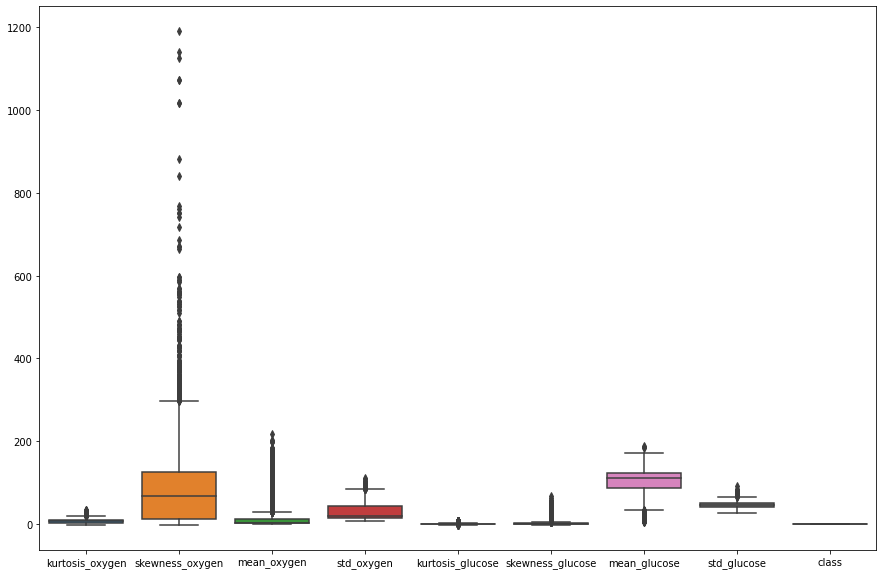

In [45]:
fig_a = plt.subplots(figsize = (15, 10))
sns.boxplot(data = data_backup[columns_backup])

#### Upravené dáta

<AxesSubplot:>

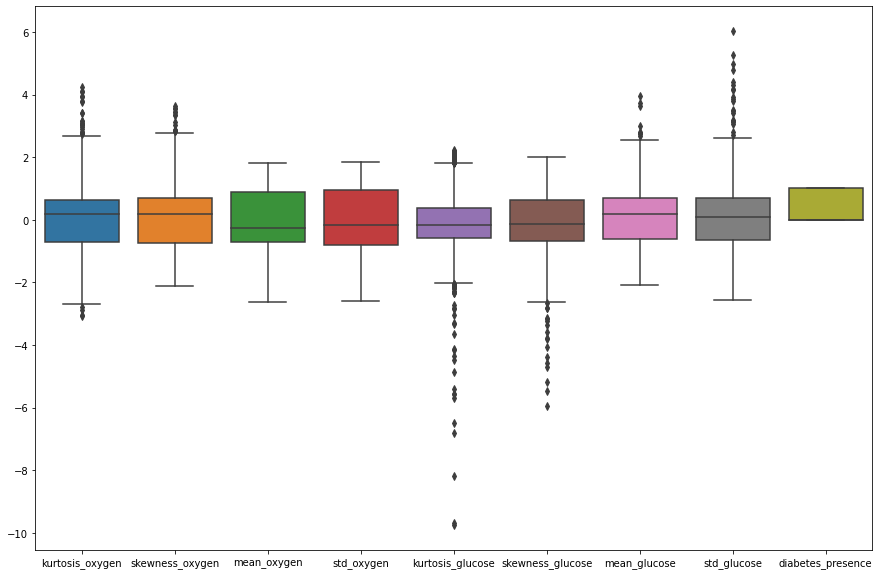

In [46]:
fig_b = plt.subplots(figsize = (15, 10))
sns.boxplot(data = new_X_1[columns])

<AxesSubplot:>

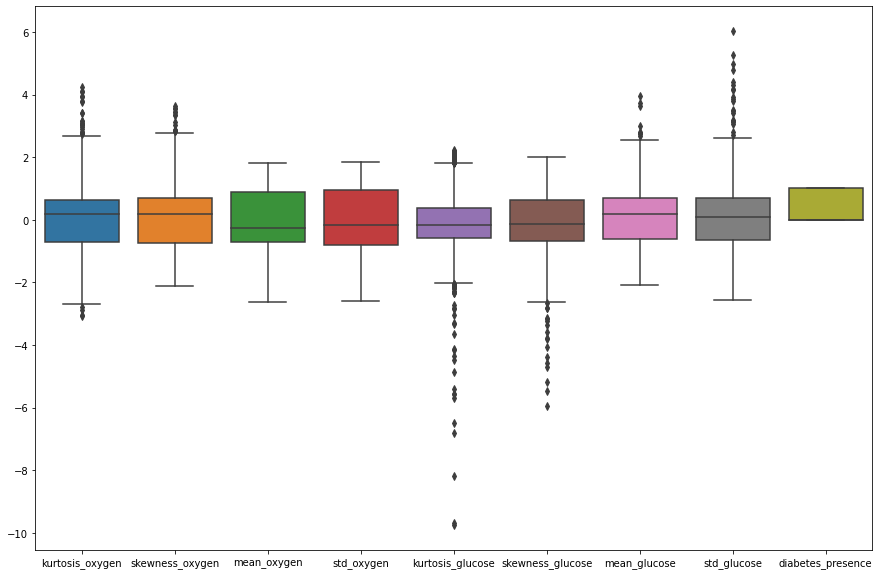

In [47]:
fig_b = plt.subplots(figsize = (15, 10))
sns.boxplot(data = new_X_2[columns])

#### Pôvodné dáta

array([[<AxesSubplot:title={'center':'kurtosis_oxygen'}>,
        <AxesSubplot:title={'center':'skewness_oxygen'}>,
        <AxesSubplot:title={'center':'mean_oxygen'}>],
       [<AxesSubplot:title={'center':'std_oxygen'}>,
        <AxesSubplot:title={'center':'kurtosis_glucose'}>,
        <AxesSubplot:title={'center':'skewness_glucose'}>],
       [<AxesSubplot:title={'center':'mean_glucose'}>,
        <AxesSubplot:title={'center':'std_glucose'}>,
        <AxesSubplot:title={'center':'class'}>]], dtype=object)

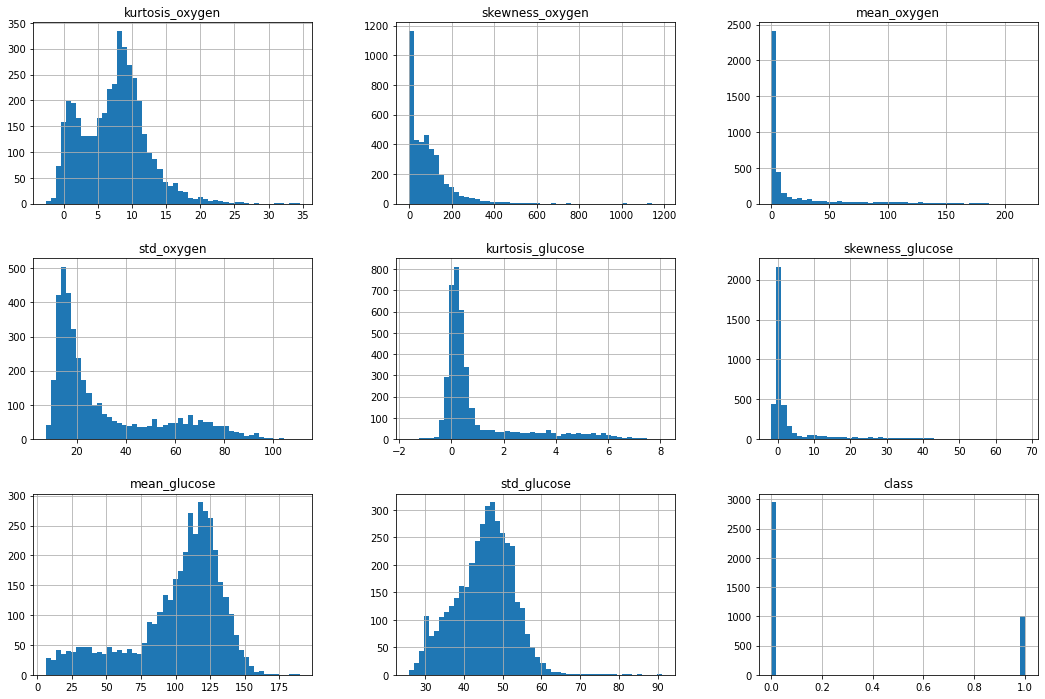

In [48]:
data_backup[columns_backup].hist(figsize = (18, 12), bins = 50)

#### Upravené dáta

array([[<AxesSubplot:title={'center':'kurtosis_oxygen'}>,
        <AxesSubplot:title={'center':'skewness_oxygen'}>,
        <AxesSubplot:title={'center':'mean_oxygen'}>],
       [<AxesSubplot:title={'center':'std_oxygen'}>,
        <AxesSubplot:title={'center':'kurtosis_glucose'}>,
        <AxesSubplot:title={'center':'skewness_glucose'}>],
       [<AxesSubplot:title={'center':'mean_glucose'}>,
        <AxesSubplot:title={'center':'std_glucose'}>,
        <AxesSubplot:title={'center':'diabetes_presence'}>]], dtype=object)

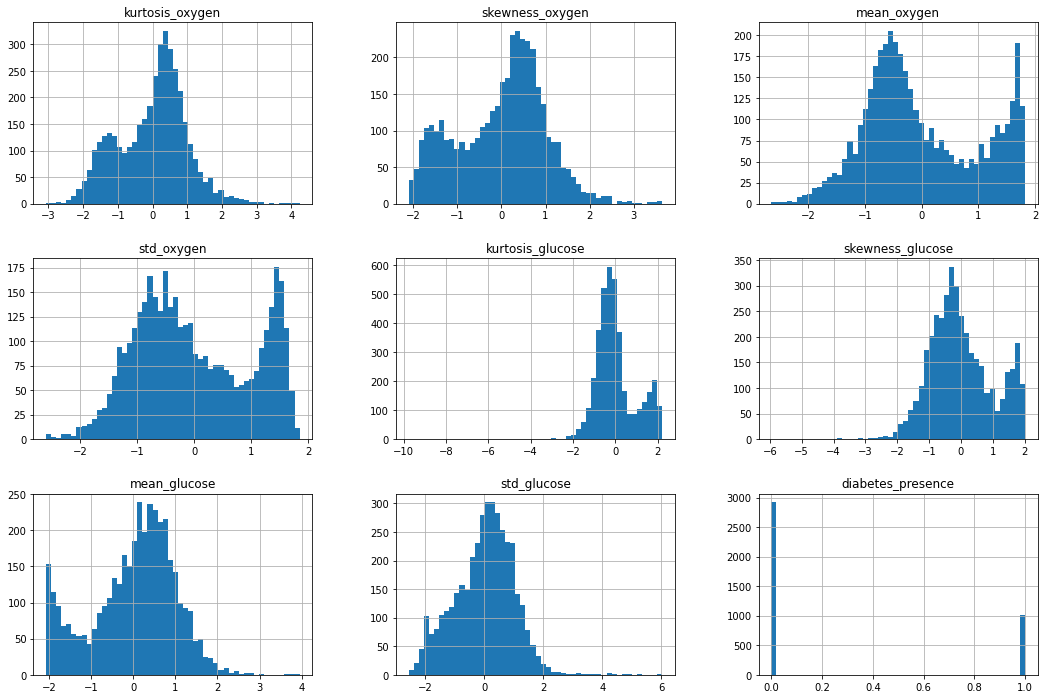

In [49]:
new_X_1[columns].hist(figsize = (18, 12), bins = 50)

array([[<AxesSubplot:title={'center':'kurtosis_oxygen'}>,
        <AxesSubplot:title={'center':'skewness_oxygen'}>,
        <AxesSubplot:title={'center':'mean_oxygen'}>],
       [<AxesSubplot:title={'center':'std_oxygen'}>,
        <AxesSubplot:title={'center':'kurtosis_glucose'}>,
        <AxesSubplot:title={'center':'skewness_glucose'}>],
       [<AxesSubplot:title={'center':'mean_glucose'}>,
        <AxesSubplot:title={'center':'std_glucose'}>,
        <AxesSubplot:title={'center':'diabetes_presence'}>]], dtype=object)

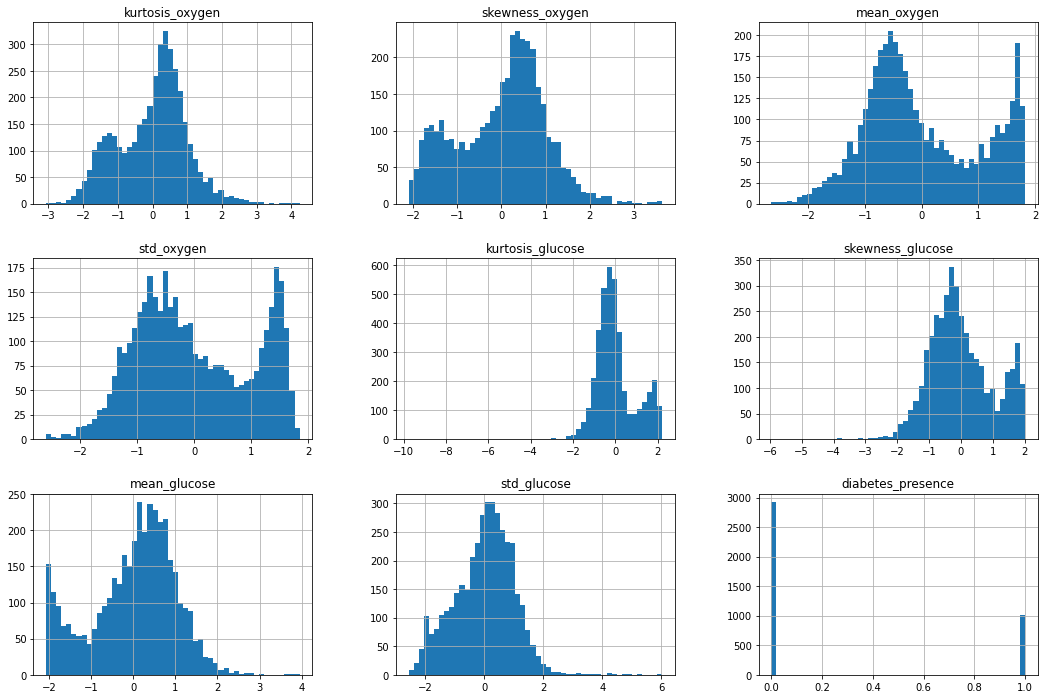

In [50]:
new_X_2[columns].hist(figsize = (18, 12), bins = 50)

#### Pôvodné dáta

<AxesSubplot:>

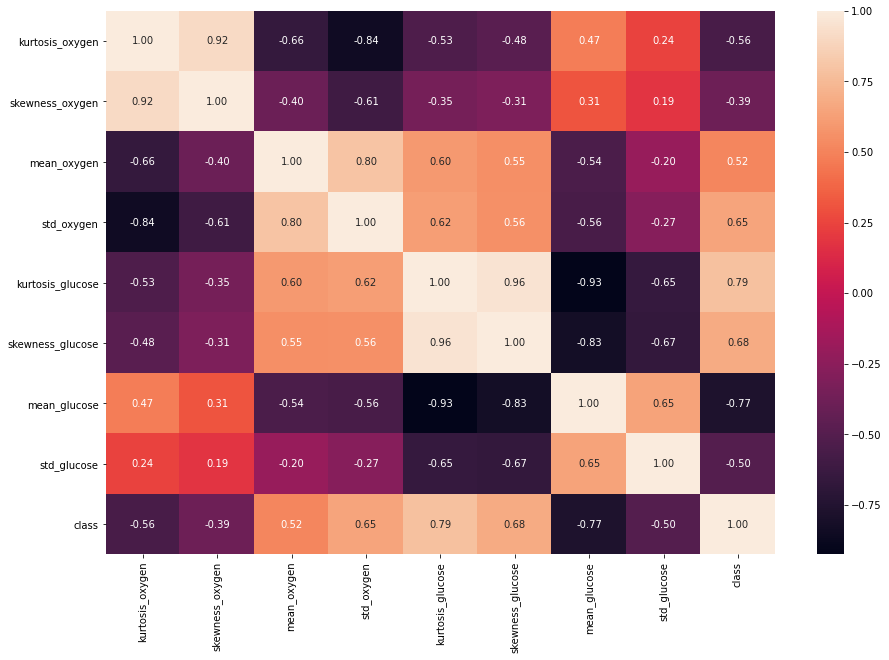

In [51]:
fig_c = plt.subplots(figsize = (15, 10))
sns.heatmap(data_backup[columns_backup].corr(), fmt = ".2f", annot = True)

#### Upravené dáta

<AxesSubplot:>

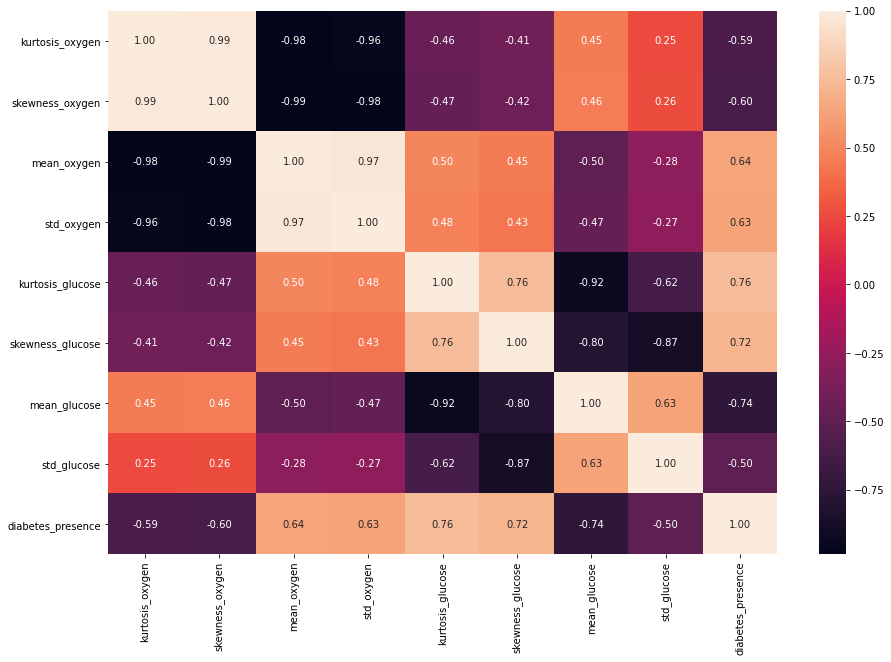

In [52]:
fig_d = plt.subplots(figsize = (15, 10))
sns.heatmap(new_X_2[columns].corr(), fmt = ".2f", annot = True)